In [1]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as tv
import torch.optim as optim
from PIL import Image
import logging
import matplotlib.pyplot as plt
import glob
import GAN
%matplotlib inline

In [2]:
mylogs = logging.getLogger()
mylogs.setLevel(logging.INFO)
# Logging to file
file = logging.FileHandler("processing.log", mode='w')
file.setLevel(logging.INFO)
fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
file.setFormatter(fileformat)
mylogs.addHandler(file)
# Logging to console
stream = logging.StreamHandler()
stream.setLevel(logging.INFO)
mylogs.addHandler(stream)
torch.cuda.empty_cache()

In [3]:
image_transform = tv.Compose([
        tv.ToTensor()
    ])

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylogs.info(f"Device is: {str(device)}")

Device is: cpu


In [5]:
def load_model(model_path):
    ''' Loads a model and its state dict. Accepts path to the model, returns the model '''
    saved_model = torch.load(f'{model_path}')
    model_name  = saved_model['model_name']
    model_state_dict = saved_model['model_state_dict']
    mylogs.info("Model: " + model_name)
    #########
    model = GAN.Generator(in_channels=3, num_channels = 64)
    model.load_state_dict(model_state_dict)
    return model

model_path = 'Resolution augmentation_Hi_Res_DCGAN_generator.pt'
model = load_model(model_path)

Model: Hi_Res_DCGAN


In [6]:
def load_img(img_path):
    '''Loads and prepares an image for the model'''
    img = Image.open(img_path)
    img = image_transform (img)
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img)
    return img

image_path= r'e://images/low_resolution/test_hist.png'
image = load_img(image_path)

In [7]:
def show_image(img, hi_res_img):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
    ax1.set_title("Original image")
    ax2.set_title("Upscaled image")
    ax1.imshow(img)
    ax2.imshow(hi_res_img)
    plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


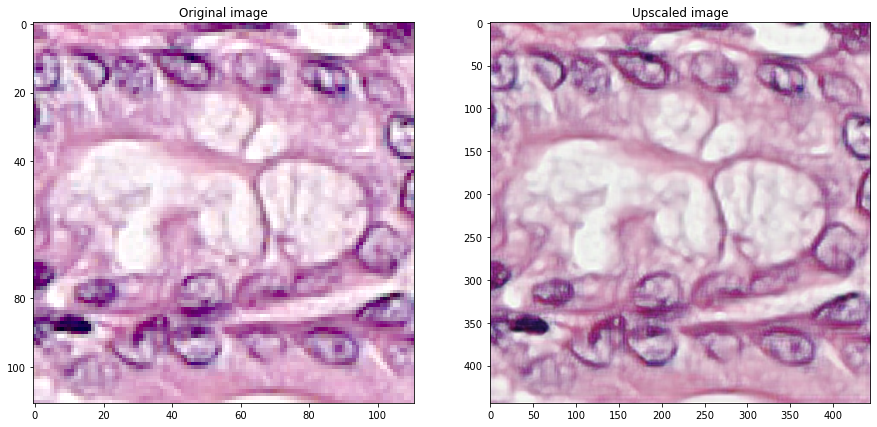

In [8]:
def hi_res_upscale(image, model, show_results=False):
    'Returns and optionaly displays a GAN upscaled image'
    image = image.to(device)
    model = model.to(device)
    hi_res_image = model(image)
    hi_res_image = hi_res_image.squeeze().permute(1,2,0).detach().numpy()
    image = image.squeeze().permute(1,2,0).detach().numpy()
    if show_results:
        show_image(image, hi_res_image)
    return hi_res_image

hi_res_image = hi_res_upscale(image, model, show_results=True)

In [9]:
def batch_prediction(images_folder_path,image_save_path, model):
    ''' Upscales images, saves resultsa in the predefined folder'''
    imgs_path_list = glob.glob(f'{images_folder_path}\*')
    mylogs.info(f"Upscaling started. \n {len(imgs_path_list)} images to upscale")
    if not image_save_path:
        save_path = images_folder_path    
    start_time = time.time()
    for img_path in imgs_path_list:
        image = load_img(img_path )
        hi_res_image = hi_res_upscale(image, model, show_results=False)
        img = Image.fromarray((hi_res_image * 230).astype(np.uint8))
        img.save(image_save_path + "\\" + os.path.basename(img_path).split('.')[0] + ".tiff")
        
    end_time = time.time()
    total_time = int(end_time - start_time)
    mylogs.info(f'Upscaling finished. Elapsed time: {total_time }s')

In [10]:
images_folder_path = r'e://images/low_resolution'
save_path = r'e://images/upscale'
batch_prediction(images_folder_path, save_path, model)

Upscaling started. 
 8 images to upscale
Upscaling finished. Elapsed time: 28s
